## Financial analysis can be conducted in three distinct ways:
- Fundamental analysis 
- Technical analysis 
- Quantitative analysis 

#### Fundamental analysis
Market price vs intrinsic value 
Absolute (cash flow, risk, growth rate, terminal value) vs relative valuation (PE, P/BV, EV/EBITDA ratios)

#### Technical analysis
Pricing game
History repeats itself
How could it be explained?

#### Quantitative analysis
Random walk & diffusion process
Probability & distribution 
Modelling

###### Standardized Normal Distrobition:
$$
\frac{1}{\sqrt{2\pi}}\exp^{-\frac{1}{2}\phi^2}
$$

In [1]:
# Import required libraries
import pandas as pd
import numpy as np

# Import data libraries
import yfinance as yf

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

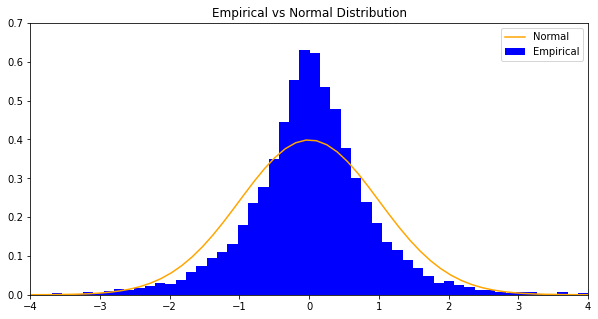

In [4]:
import matplotlib.pyplot as plt

spx = yf.download('^GSPC', start='1970-01-01', end='2020-10-31', progress=False)['Adj Close']
spx_ret = spx.pct_change().dropna()
scalled_ret = (spx_ret - spx_ret.mean())/spx_ret.std()

# Define bins
x = np.linspace(scalled_ret.min(), scalled_ret.max(), 200)

# Calculate normal probability density function
y = (1/np.sqrt(2*np.pi)*np.exp(-0.5*x**2))

# Plot histogram of scaled returns
plt.figure(figsize=(10,5))
plt.hist(scalled_ret, bins=200, density=True, color = 'blue', label = 'Empirical', alpha=1)

# Plot norm pdf
plt.plot(x, y, color = 'orange', label = 'Normal')

# Set x and y axis limits
plt.xlim(-4,4)
plt.ylim(0,0.7)

plt.title('Empirical vs Normal Distribution')
plt.legend();

$$
R_i = \frac{P_{i+1}-P_i}{P_i} = mean + vol.\phi\\
mean = \mu\delta_t\\
vol = \sigma\delta_t^{\frac{1}{2}}\\
$$
So we have a descret-time model for a **random walk**:
$$
R_t = \mu\delta_t + \sigma\phi\delta_t^{\frac{1}{2}}\\
P_{i+1}-P_{i}= \mu P_{i}\delta_t + \sigma P_{i}\phi\delta_t^{\frac{1}{2}}\\
$$

### Diversification

In [5]:
# Define the parameters
stocks = ['TSLA', 'AMZN']
start_date = '2017-11-01'
end_date = '2020-10-30'
# Fetching data for multiple tickers
prices = yf.download(stocks, start=start_date, end=end_date, progress=False)['Adj Close']
prices.head()

,AMZN,TSLA
Date,,
2017-10-31,1105.280029,66.306000
2017-11-01,1103.680054,64.216003
2017-11-02,1094.219971,59.852001
2017-11-03,1111.599976,61.217999
2017-11-06,1120.660034,60.556000


In [6]:
rets = prices.pct_change().dropna()
rets.head()

,AMZN,TSLA
Date,,
2017-11-01,-0.001448,-0.031520
2017-11-02,-0.008571,-0.067958
2017-11-03,0.015883,0.022823
2017-11-06,0.008150,-0.010814
2017-11-07,0.002240,0.010800


In [7]:
ann_rets = (1+rets).prod()**(252/rets.shape[0])-1
ann_vol = rets.std()*(252**0.5)

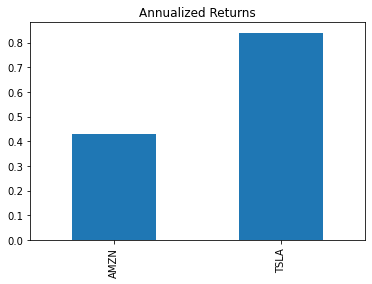

In [8]:
ann_rets.plot(kind='bar',title='Annualized Returns')

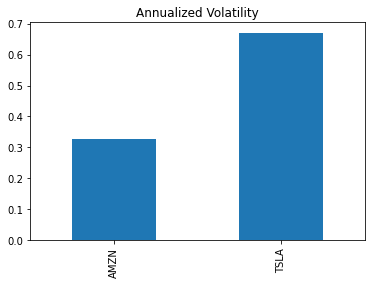

In [9]:
ann_vol.plot(kind='bar', title='Annualized Volatility')

In [10]:
r = rets.corr()
r

,AMZN,TSLA
AMZN,1.000000,0.400724
TSLA,0.400724,1.000000


The vector of expected returns $\mu$ is defined as:
$$
\mu=
\begin{Bmatrix}
\mu_1\\
\mu_2
\end{Bmatrix}
$$

The covariance matrix $\Sigma$ is given by:
$$
\Sigma=
\begin{Bmatrix}
\sigma^2_1 & \rho_{12}\sigma_1\sigma_2\\
\rho_{21}\sigma_2\sigma_1 & \sigma^2_2 
\end{Bmatrix}
$$

The vector of weights is:
$$
w=
\begin{Bmatrix}
w_1\\
w_2
\end{Bmatrix}
$$

The portfolio return ($\mu_\pi$) is then given by:
$$
\mu_{\pi} = w'\mu
$$

and the portfolio variance is:
$$
\sigma^2_{\pi} = w'\Sigma^{-1}w
$$


In [11]:
weights = np.array([0.5, 0.5])
weights.T @ ann_rets

0.633945264125851

In [12]:
((weights.T @ rets.cov() @ weights)**0.5)*(252**0.5)

0.42755158013329825

In [13]:
ret = pd.DataFrame({'Amazon': [ann_rets[0]],
                    'Tesla': [ann_rets[1]],
                    '50-50 Portfolio': [weights.T @ ann_rets]})

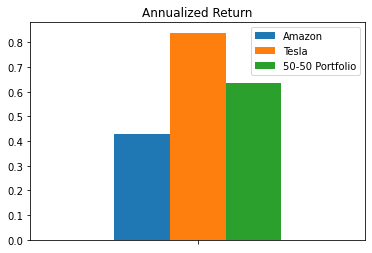

In [14]:
import matplotlib.pyplot as plt
ret.plot(kind='bar',title='Annualized Return')
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
plt.show()

In [15]:
vol = pd.DataFrame({'Amazon': [ann_vol[0]],
                    'Tesla': [ann_vol[1]],
                    '50-50 Portfolio': [((weights.T @ rets.cov() @ weights)**0.5)*(252**0.5)]})

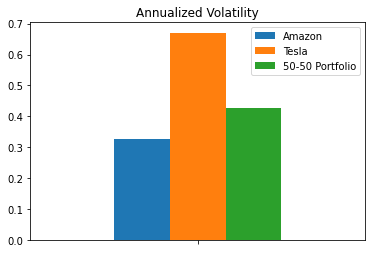

In [16]:
import matplotlib.pyplot as plt
vol.plot(kind='bar',title='Annualized Volatility')
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
plt.show()

In [17]:
import numpy as np

sample_size = 25
weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, sample_size)]

In [18]:
port_rets = [w.T @ ann_rets for w in weights]
port_vols = [((w.T @ rets.cov() @ w)**0.5)*(252**0.5) for w in weights]

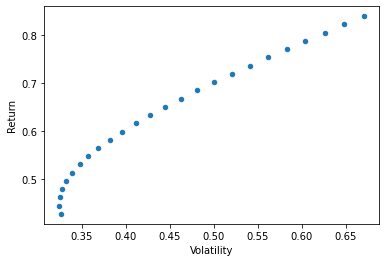

In [19]:
risk_return = pd.DataFrame({"Return": port_rets, "Volatility": port_vols}).plot.scatter(x="Volatility", y="Return")

In [20]:
#Find your directory
import os
cwd = os.getcwd()
cwd

'/Users/constantinechung/Desktop/Python for Financial Markets'

### Efficient Frontier

In [23]:
import pandas as pd
import xlwings as xw

import numpy as np
from numpy import *
from numpy.linalg import multi_dot

import matplotlib.pyplot as plt
import yfinance as yf

# FAANG stocks
symbols = ['AAPL', 'AMZN', 'FB', 'GOOG', 'NFLX' ]
numofasset = len(symbols)
df = yf.download(symbols, start='2013-01-01' , end='2020-10-30', progress=False)['Adj Close']

numofportfolio = 5000
# # Visualize the data
# fig = plt.figure(figsize=(16,8))
# ax = plt.axes()

# ax.set_title('Normalized Price Plot')
# ax.plot(df[-252:]/df.iloc[-252] * 100)
# ax.legend(df.columns, loc='upper left')
# ax.grid(True)

In [24]:
ret = df.pct_change().dropna()
ret.head()

,AAPL,AMZN,FB,GOOG,NFLX
Date,,,,,
2013-01-02,0.031681,0.025671,0.051841,0.022435,-0.006264
2013-01-03,-0.012622,0.004547,-0.008214,0.000581,0.049777
2013-01-04,-0.027855,0.002592,0.035650,0.019760,-0.006315
2013-01-07,-0.005882,0.035925,0.022949,-0.004363,0.033549
2013-01-08,0.002692,-0.007748,-0.012237,-0.001974,-0.020565


In [25]:
ann_ret = (1+ret).prod()**(252/ret.shape[0])-1
ann_ret

AAPL    0.281367
AMZN    0.385119
FB      0.351320
GOOG    0.210110
NFLX    0.592403
dtype: float64

In [26]:
ann_vol = ret.std()*(252**0.5)
ann_vol

AAPL    0.285472
AMZN    0.306644
FB      0.344673
GOOG    0.257412
NFLX    0.460919
dtype: float64

In [27]:
wts = np.repeat(1/numofasset, numofasset)
port_ret = wts.T @ ann_ret
port_vol = sqrt(multi_dot([wts.T,ret.cov()*252,wts]))

In [28]:
w = random.random(numofasset)
w

array([0.94416371, 0.73945392, 0.45076115, 0.83227364, 0.4980372 ])

In [29]:
# wts = w/sum(w)
w /= sum(w)

In [30]:
sim_rets = []
sim_vols = []
sim_w = []
for i in range(numofportfolio):
    w = random.random(numofasset)
    w /= sum(w)
    sim_rets.append(w.T @ ann_ret)
    sim_vols.append(sqrt(multi_dot([w.T,ret.cov()*252,w])))
    sim_w.append(w)

In [31]:
# Create a dataframe for analysis
sim_df = pd.DataFrame({'returns': sim_rets,
                      'volatility': sim_vols,
                      'weights': list(sim_w)})
sim_df.head()

,returns,volatility,weights
0,0.353262,0.248020,"[0.2589459804630177, 0.13040806750533698, 0.02..."
1,0.317797,0.239050,"[0.3224859741032586, 0.41830566352678117, 0.00..."
2,0.343063,0.247387,"[0.27489322214954914, 0.024957898679883614, 0...."
3,0.313908,0.247726,"[0.0649517918377376, 0.05865907792473548, 0.26..."
4,0.314160,0.243604,"[0.07823539024334866, 0.39260490526926756, 0.0..."


In [32]:
# assume that risk free rate is 0%
sim_df['sharpe ratio'] = sim_df['returns']/sim_df['volatility']
sim_df.head()

,returns,volatility,weights,sharpe ratio
0,0.353262,0.248020,"[0.2589459804630177, 0.13040806750533698, 0.02...",1.424329
1,0.317797,0.239050,"[0.3224859741032586, 0.41830566352678117, 0.00...",1.329417
2,0.343063,0.247387,"[0.27489322214954914, 0.024957898679883614, 0....",1.386743
3,0.313908,0.247726,"[0.0649517918377376, 0.05865907792473548, 0.26...",1.267160
4,0.314160,0.243604,"[0.07823539024334866, 0.39260490526926756, 0.0...",1.289633


In [33]:
# Max sharpe ratio portfolio 
msrp = sim_df.iloc[sim_df['sharpe ratio'].idxmax()]
msrp

returns                                                   0.42133
volatility                                                0.27034
weights         [0.19347434742551445, 0.3085305250207082, 0.19...
sharpe ratio                                              1.55852
Name: 3795, dtype: object

In [34]:
# Max sharpe ratio portfolio weights
max_sharpe_port_wts = sim_df['weights'][sim_df['sharpe ratio'].idxmax()]

# Allocation to achieve max sharpe ratio portfolio
dict(zip(symbols,np.around(max_sharpe_port_wts*100,2)))

{'AAPL': 19.35, 'AMZN': 30.85, 'FB': 19.19, 'GOOG': 0.17, 'NFLX': 30.43}

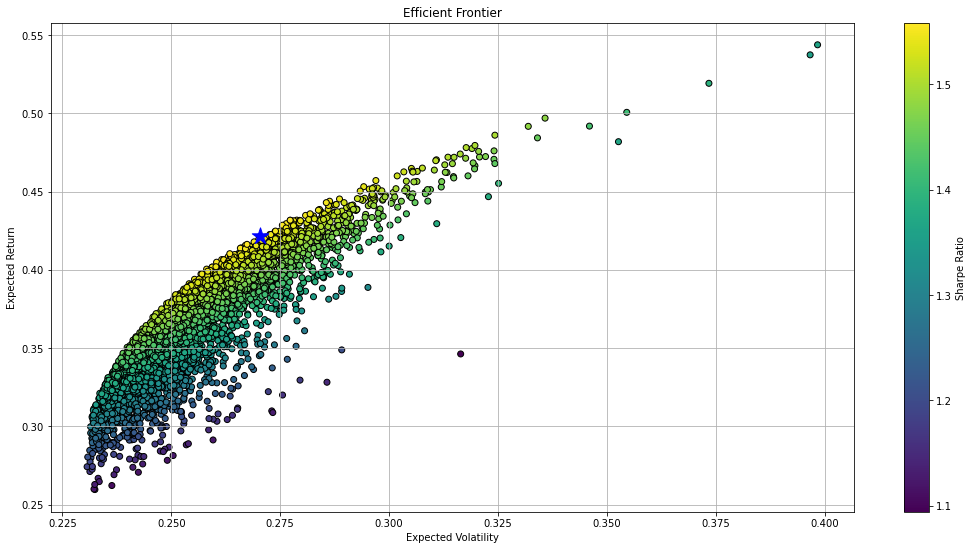

In [54]:
fig = plt.figure(figsize=(18,9))
ax = plt.axes()

ax.set_title('Efficient Frontier')

# Simulated portfolios
fig.colorbar(ax.scatter(sim_vols, sim_rets, c=sim_df['returns']/sim_df['volatility'], 
                        marker='o', edgecolors='black'), label='Sharpe Ratio') 

# Maximum sharpe ratio portfolio
ax.scatter(msrp['volatility'], msrp['returns'], c='blue', marker='*', s = 300, label='Max Sharpe Ratio')

ax.set_xlabel('Expected Volatility')
ax.set_ylabel('Expected Return')
ax.grid(True)

fig.savefig('Efficient Frontier.pdf')

### Diworsification

In [37]:
stocks = ['URTH', 'IVV']
start_date = '2015-11-01'
end_date = '2020-10-30'
# Fetching data for multiple tickers
prices = yf.download(stocks, start=start_date, end=end_date, progress=False)['Adj Close']
rets = prices.pct_change().dropna()
rets.head()

,IVV,URTH
Date,,
2015-11-03,0.002505,0.003055
2015-11-04,-0.002593,-0.003877
2015-11-05,-0.001229,0.003753
2015-11-06,-0.000379,-0.006093
2015-11-09,-0.009610,-0.010448


In [38]:
def Drawdowns(returns):
    wealth_index = 1000*(1+returns).cumprod()
    pre_peak = wealth_index.cummax()
    drawdown = (wealth_index - pre_peak)/pre_peak
    return pd.DataFrame({"Wealth": wealth_index, "Previous Peak": pre_peak, "Drawdown": drawdown})

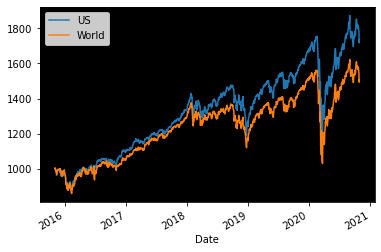

In [39]:
pd.DataFrame({'US':Drawdowns(rets['IVV'])['Wealth'], 'World':Drawdowns(rets['URTH'])['Wealth']}).plot()
ax = plt.gca()
ax.patch.set_facecolor('black')

## Modern Portfolio Theory (MPT)

### CAPM
Introduced by Sharpe [1964], this is the simplest factor model to explain expected asset returns above the riskless rate with respect to the market.
$$
r^e_{i,t}= \alpha_{i,CAPM}+\beta_{i,MKT}MKT_t+\epsilon_{i,t}
$$
where $r^e_{i,t}$ is the period $t$ return on asset $i$ in excess of the risk-free rate.

Few restrictive (and unrealistic) assumptions:
- one-period world (constant investment opportunity set and risk premia over time)
- unlimited borrowing and lending at risk free
- no taxes or transaction costs
- investors are rational mean variance optimisers (normally distributed asset returns, or quadratic utility function)
- investors have homogeneous expectations

### APT
Developed by Ross [1976], APT relates stock returns to macroeconomic state variables. It does relax of the assumptions of CAPM, however, finding risk factots that explain the performance of different stocks consistently is an open problem.
$$
r^e_{i,t}= \beta_{i1,t}\lambda_{t,1}+\beta_{i2,t}\lambda_{t,2}+\dots+\beta_{in,t}\lambda_{t,n}+\epsilon_{i,t}
$$

##### Fama-French (1993):
Market + Size + Value

##### Fama-French-Carhart (1997):
Market + Size + Value + Momentum

##### Fama-French-Pastor (2003):
Market + Size + Value + Liquidity

##### Hou-Xue-Zhang (2015):
Market + Size + Investment + Profitability

##### Fama-French (2015):
Market + Size + Value + Profitability + Investment

In [40]:
stocks = ['VLUE', 'MTUM', 'SPLV', 'SPYG']
start_date = '2015-11-01'
end_date = '2020-10-30'
# Fetching data for multiple tickers
prices = yf.download(stocks, start=start_date, end=end_date, progress=False)['Adj Close']
rets = prices.pct_change().dropna()
rets = rets.rename(columns={'MTUM':'Momentum', 'SPLV':'LowVol', 'VLUE':'Value', 'SPYG':'Growth'})
rets.head()

,Momentum,LowVol,Growth,Value
Date,,,,
2015-11-03,-0.002039,-0.006441,0.000580,0.001228
2015-11-04,0.000272,-0.002074,-0.000484,-0.006284
2015-11-05,0.006672,0.002079,-0.002419,-0.000154
2015-11-06,-0.006223,-0.007780,-0.000970,0.002931
2015-11-09,-0.008983,-0.005751,-0.009709,-0.011073


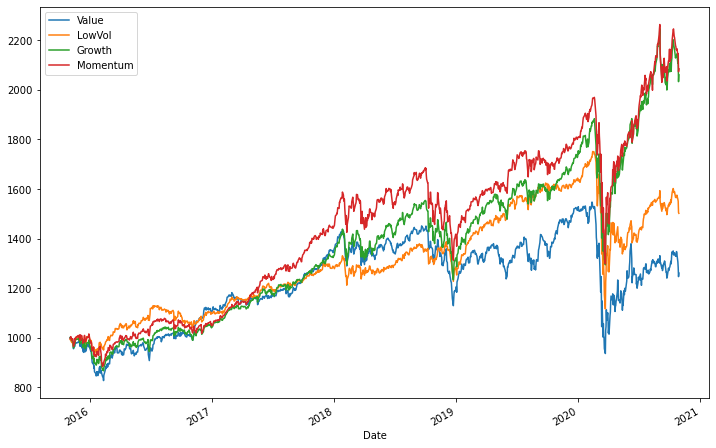

In [41]:
pd.DataFrame({'Value':Drawdowns(rets['Value'])['Wealth'],
             'LowVol':Drawdowns(rets['LowVol'])['Wealth'],
             'Growth':Drawdowns(rets['Growth'])['Wealth'],
             'Momentum':Drawdowns(rets['Momentum'])['Wealth']}).plot(figsize=(12,8))

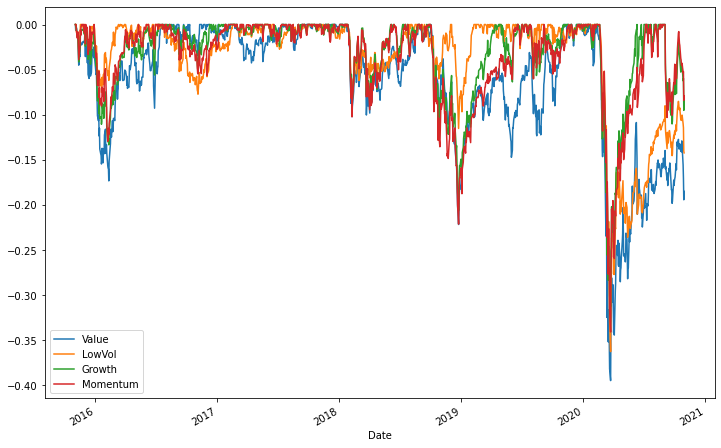

In [42]:
pd.DataFrame({'Value':Drawdowns(rets['Value'])['Drawdown'],
             'LowVol':Drawdowns(rets['LowVol'])['Drawdown'],
             'Growth':Drawdowns(rets['Growth'])['Drawdown'],
             'Momentum':Drawdowns(rets['Momentum'])['Drawdown']}).plot(figsize=(12,8))

In [43]:
rets.corr()

,Momentum,LowVol,Growth,Value
Momentum,1.000000,0.863354,0.960530,0.824510
LowVol,0.863354,1.000000,0.850798,0.827963
Growth,0.960530,0.850798,1.000000,0.887493
Value,0.824510,0.827963,0.887493,1.000000


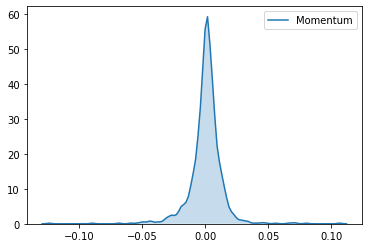

In [44]:
import seaborn as sns
sns.kdeplot(rets['Momentum'], shade=True);

In [45]:
prices.resample('M').last().pct_change().dropna().corr()

,MTUM,SPLV,SPYG,VLUE
MTUM,1.000000,0.801954,0.961093,0.780035
SPLV,0.801954,1.000000,0.785832,0.744891
SPYG,0.961093,0.785832,1.000000,0.847830
VLUE,0.780035,0.744891,0.847830,1.000000


### Active vs Passive

<img src="US.png" width="900" height="300">

<img src="International.png" width="900" height="300">

### Performance metrics

In [46]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import yfinance as yf

# FAANG stocks
symbols = ['BAC', 'ASC.L', 'BABA', 'MSFT', 'PFE' ]
numofasset = len(symbols)
df = yf.download(symbols, start='2015-11-01' , end='2020-10-30', progress=False)['Adj Close']
ret = df.pct_change().dropna()
ret = ret.rename(columns={'ASC.L':'ASOS', 'BAC':'BankofAmerica', 'BABA':'AliBaba', 'MSFT':'Microsoft', 'PFE':'Pfizer'})
ret.head()

,ASOS,AliBaba,BankofAmerica,Microsoft,Pfizer
Date,,,,,
2015-11-03,-0.000305,-0.010788,0.007034,0.017093,-0.002567
2015-11-04,0.007929,0.023490,-0.009895,0.004617,-0.015855
2015-11-05,-0.003026,-0.000234,0.017637,-0.000368,0.000293
2015-11-06,0.004856,-0.020731,0.036973,0.009930,-0.006442
2015-11-09,-0.021746,-0.026671,-0.015042,-0.013838,-0.008252


In [47]:
max_drawdown = pd.DataFrame({'ASOS':Drawdowns(ret['ASOS'])['Drawdown'],
             'BankofAmerica':Drawdowns(ret['BankofAmerica'])['Drawdown'],
             'AliBaba':Drawdowns(ret['AliBaba'])['Drawdown'],
             'Microsoft':Drawdowns(ret['Microsoft'])['Drawdown'],
             'Pfizer':Drawdowns(ret['Pfizer'])['Drawdown']}).min()

In [48]:
max_drawdown

ASOS            -0.864166
BankofAmerica   -0.489468
AliBaba         -0.380632
Microsoft       -0.280393
Pfizer          -0.354323
dtype: float64

In [49]:
def ann_ret(returns, periods):
    return (returns+1).prod()**(periods/returns.shape[0])-1

In [50]:
annualized_rets = ann_ret(ret, 252)
annualized_rets

ASOS             0.061656
AliBaba          0.293392
BankofAmerica    0.085342
Microsoft        0.327533
Pfizer           0.038302
dtype: float64

In [51]:
# CALMAR Ratio
riskfree = 0.02
Calmar_ratio = (annualized_rets - riskfree)/abs(max_drawdown)
Calmar_ratio

ASOS             0.048204
AliBaba          0.718258
BankofAmerica    0.133496
Microsoft        1.096792
Pfizer           0.051654
dtype: float64

In [52]:
def calmar_ratio(ret, rf, drawdown):
    return (ret - rf)/abs(drawdown)

In [53]:
calmar_ratio(annualized_rets, 0.02, max_drawdown)

ASOS             0.048204
AliBaba          0.718258
BankofAmerica    0.133496
Microsoft        1.096792
Pfizer           0.051654
dtype: float64

In [136]:
data = pd.read_csv("data.csv", header=0, index_col=0, parse_dates=True)
data.head()

,Fund1,Fund2,Fund3,BM
Date,,,,
2010-01-04,11.11,14.20,18.51,1132.98
2010-01-05,11.12,14.24,18.56,1136.52
2010-01-06,11.05,14.35,18.58,1137.14
2010-01-07,11.06,14.33,18.65,1141.70
2010-01-08,11.11,14.46,18.72,1144.98


In [162]:
fund_ret = data[['Fund1', 'Fund2', 'Fund3']].pct_change().dropna()
bm_ret = data[['BM']].pct_change().dropna()

In [164]:
def sharpe_ratio(r, rf, periods):
    """
    r: returns
    n: number of periods per year (e.g. for monthly data n=12) 
    rf: risk free rate
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+rf)**(1/periods)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = ann_ret(excess_ret, periods)
    ann_volatility = ann_vol(r, periods)
    return ann_ex_ret/ann_volatility

In [165]:
sharpe_ratio(fund_ret, 0.02, 252)

Fund1    0.267310
Fund2    0.524344
Fund3    0.049308
dtype: float64

In [140]:
def ann_vol(r, periods):
    """
    r: returns
    n: number of periods per year (e.g. for monthly data n=12)    
    """
    return r.std()*(periods**0.5)

In [147]:
annualized_fund_rets = ann_ret(fund_ret, 252)
annualized_bm_rets = ann_ret(bm_ret, 252)
annualized_fund_vol = ann_vol(fund_ret, 252)

In [154]:
info_ratio = (annualized_fund_rets - annualized_bm_rets[0])/annualized_fund_vol
info_ratio

Fund1   -0.203218
Fund2   -0.100352
Fund3   -0.440981
dtype: float64

### Higher Frequency Data

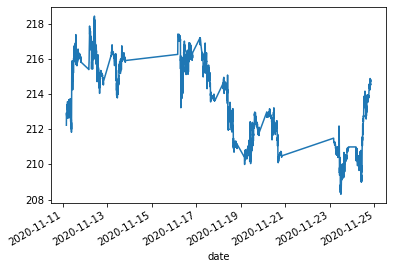

In [95]:
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='YOUR_API_KEY', output_format='pandas')
data, meta_data = ts.get_intraday(symbol='MSFT',interval='1min', outputsize='full')
data['4. close'].plot()